In [1]:
using PMDPs
using Test
using POMDPSimulators

using StaticArrays
using POMDPs
using MCTS, DiscreteValueIteration
using StatsBase
using Plots
using POMDPSimulators
using D3Trees
using POMDPPolicies
using POMDPLinter
using Random
using DataFrames
# using CSV
# using CSVFiles
using BSON
using POMDPSimulators

using DrWatson
using Distributions
using BeliefUpdaters

using Plots
using Latexify

┌ Info: Precompiling PMDPs [970633d0-fc35-4d62-9bcd-e74aee58f016]
└ @ Base loading.jl:1278
┌ Warning: Module OrderedCollections with build ID 151762432771501 is missing from the cache.
│ This may mean OrderedCollections [bac558e1-5e72-5ebc-8fee-abe8a469f55d] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1017
┌ Warning: Module OrderedCollections with build ID 151762432771501 is missing from the cache.
│ This may mean OrderedCollections [bac558e1-5e72-5ebc-8fee-abe8a469f55d] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1017
┌ Warning: Module OrderedCollections with build ID 151762432771501 is missing from the cache.
│ This may mean OrderedCollections [bac558e1-5e72-5ebc-8fee-abe8a469f55d] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1017
┌ Warning: Module OrderedCollections with build ID 151762432771501 is missing from the cache.
│ This may mean Ordered

# Plan

Graphs I want:

- big:
 - demand-revenue
 - n_iter-revenue %tohle asi ne.

- small:
 - demand-revenue
 - demand-utilization


In [3]:
plot_size = ((1+sqrt(5))/2, 1).*100 .*3
label_demand = "Expected number of requests (λ)"
label_demand = "Expected demand"

"Expected demand"

In [4]:
# res = DrWatson.collect_results(joinpath(datadir(), "results", "linear_problem"));

In [5]:
res_folder = joinpath(datadir(), "results", "linear_problem")
res_files = readdir(res_folder)
    
res = BSON.load(joinpath(res_folder,res_files[1]))

Dict{Any,Any} with 5 entries:
  :pp_params        => Dict{Symbol,Any}(:T=>10,:c=>3,:res_budget_μ=>5.0,:nᵣ=>3,…
  :agg              => 4×7 DataFrame…
  :(string(method)) => "fhvi"
  :results          => 1×8 DataFrame…
  :(data[:name])    => "linear_problem"

In [6]:
function res2row(res)
    row_dfs = []
    
    # process pp_params into df with single row
    row = DataFrame(res[:pp_params])
    push!(row_dfs, row)
    
    # process agg: move evry row from "description" into single dataframe of one row
    agg = select(res[:agg], [:variable, :mean, :median, :min, :max])
    for row in eachrow(agg)
        v = string(row.variable)
        row = DataFrame(row[2:end])
        rename!(s-> s*"_$v", row)
        push!(row_dfs, row)
    end
    
    # compact dfs into single row
    df = hcat(row_dfs...)
    
    # add method name
    method = first(res[:results]).name
    insertcols!(df, 1, :method=>method)
end

res_folder = joinpath(datadir(), "results", "graph_problem")
res_files = readdir(res_folder)
    
res = BSON.load(joinpath(res_folder,res_files[1]))

res2row(res)

,method,NE,NP,NV,T,c,expected_res,res_budget_μ,seed
,Symbol,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Int64
1,flatrate,20,50,8,1000,10,400.0,5.0,1


In [7]:
res_folder = joinpath(datadir(), "results", "linear_problem")
res_files = readdir(res_folder)

rows = []
for res_file in res_files
    res = BSON.load(joinpath(res_folder,res_file))
    row = res2row(res)
    push!(rows, row)
end

results = vcat(rows...);
sort!(results, [:method, :expected_res]);

In [8]:
results

,method,T,c,expected_res,nᵣ,res_budget_μ,mean_r,median_r,min_r
,Symbol,Int64,Int64,Float64,Int64,Float64,Float64,Float64,Any
1,fhvi,10,3,3.0,3,5.0,17.5,17.5,17.5
2,flatrate,1000,40,50.0,10,5.0,140.0,160.0,40.0
3,flatrate,1000,40,100.0,10,5.0,233.333,280.0,105.0
4,flatrate,1000,40,150.0,10,5.0,309.167,332.5,192.5
5,flatrate,1000,40,200.0,10,5.0,443.333,490.0,332.5
6,flatrate,1000,40,250.0,10,5.0,540.0,500.0,440.0
7,flatrate,1000,40,300.0,10,5.0,682.5,682.5,595.0
8,flatrate,1000,40,350.0,10,5.0,840.0,820.0,760.0
9,flatrate,1000,40,400.0,10,5.0,816.667,805.0,787.5


In [9]:
grps = groupby(results, :method);

In [10]:
plot()
for gr in grps
    plot!(gr.expected_res, gr.mean_r, label=first(gr).method)
end
plot!()

LoadError: ArgumentError: unsupported symbol fhvi passed to `label`

In [11]:
plot(edf1[!, x_param], edf1.r_mc,
    xlabel = label_demand,
    ylabel = "Utilization",
    label = "MCTS",
    m=(3, :circle), 
    size=plot_size,
    legend=:topleft
)
plot!(edf1[!, x_param], edf1.r_vi,  m=(3, :square, :black), line=(:black), label="VI")
plot!(edf1[!, x_param], edf1.r_flat,  m=(3, :dtriangle, :red), line=(:red), label="flat-rate")
plot!(edf1[!, x_param], edf1.r_hind,  m=(3, :utriangle, :green), line=(:green), label="hindsight")


LoadError: UndefVarError: edf1 not defined

# Old Code

In [12]:
function get_result(df::DataFrame, c::Symbol, method::Symbol)
    [nt[method] for nt in df[!, c]]
end

function get_param(df::DataFrame, pt::Symbol, p::Symbol)
    [d[pt][p] for d in df[!, :params]]
end

get_param (generic function with 1 method)

# Experiment with varying n_iterations

In [13]:
# mdp_dir = readdir(datadir("sims"))[2]
# exp = readdir(datadir("sims", mdp_dir))[1]
# # res = wload(datadir("sims", mdp_dir, exp))
# mdp_dir

# mdp_dir = readdir(datadir("sims"))[2]
# exp = readdir(datadir("sims", mdp_dir))[1]
# # res = wload(datadir("sims", mdp_dir, exp))

df = collect_results(
    datadir("sims", "exp_n_iter");
    white_list = [:r, :u, :t, :params], subfolders=true
)

┌ Info: Scanning folder /home/mrkos/projects/PMDPs/data/sims/exp_n_iter for result files.
└ @ DrWatson /home/mrkos/.julia/packages/DrWatson/NuoB0/src/result_collection.jl:88


LoadError: SystemError: unable to read directory /home/mrkos/projects/PMDPs/data/sims/exp_n_iter: No such file or directory

In [14]:
r_flat =  get_result(df, :r, :flat)
r_mc=get_result(df, :r, :mc)
r_hind =get_result(df, :r, :hind);

n_runs = get_param(df, :exp, :n_runs)
n_iterations = get_param(df, :mcts, :n_iterations) 
depth = get_param(df, :mcts, :depth);

mdf = DataFrame(@dict r_flat r_mc r_hind n_runs n_iterations depth )

sort!(mdf)

LoadError: UndefVarError: df not defined

In [15]:
edf1 = mdf
sort!(edf1)
x_param = :n_iterations
label_n_iter = "MCTS Iterations"

plot(edf1[!, x_param], edf1.r_mc,
    xlabel = label_n_iter,
    ylabel = "Revenue",
    label = "MCTS",
    m=(3, :circle), 
    size=plot_size,
    legend=:topleft
)
plot!(edf1[!, x_param], edf1.r_flat[1]*ones(length(edf1.r_mc)),  m=(3, :dtriangle), line=(:red), label="flat-rate")
plot!(edf1[!, x_param], edf1.r_hind[1]*ones(length(edf1.r_mc)),  m=(3, :utriangle), line=(:green), label="hindsight")

LoadError: UndefVarError: mdf not defined

In [16]:
save(datadir("exp_pro", "exp_big_niter.csv"), mdf)

LoadError: UndefVarError: mdf not defined

In [17]:
savefig(papersdir("paper_AAMAS2021_MCTS_pricing", "fig", "plt_big_niter.pdf"))

In [18]:
filter(row -> row.n_iterations==50000, mdf)

LoadError: UndefVarError: mdf not defined

# Varying demand - BIG

In [47]:
df = collect_results( datadir("sims", "exp_demand");
    white_list = [:r, :u, :t, :params], subfolders=true)

┌ Info: Scanning folder C:\Users\Honza\scth\projects\julia\PricingMDP\data\sims\exp_demand for result files.
└ @ DrWatson C:\Users\Honza\.julia\packages\DrWatson\YmBBf\src\result_collection.jl:88
Error encountered while loading "C:\\Users\\Honza\\scth\\projects\\julia\\PricingMDP\\data\\sims\\exp_demand\\c_init=30_n_edges=10_1d2d82f12adbd23e\\n_runs=10_save=stats_vi=false_depth=100_exploration_constant=40_keep_tree=true_n_iterations=10000.bson".

Fatal error:


ErrorException: invalid struct allocation

In [123]:
r_flat =  get_result(df, :r, :flat)
r_mc=get_result(df, :r, :mc)
r_hind =get_result(df, :r, :hind);

n_runs = get_param(df, :exp, :n_runs)
n_iterations = get_param(df, :mcts, :n_iterations) 
demand = map(sum, get_param(df, :mdp, :demand))

mdf = DataFrame(@dict r_flat r_mc r_hind n_runs n_iterations demand )
sort!(mdf)

,demand,n_iterations,n_runs,r_flat,r_hind,r_mc
,Float64,Int64,Int64,Float64,Float64,Float64
1,5.0,10000,10,333.0,740.7,387.1
2,10.0,10000,10,639.9,1349.7,682.3
3,15.0,10000,10,851.5,1853.2,909.5
4,20.0,10000,10,1025.0,2330.7,1204.6
5,25.0,10000,10,1236.7,2816.9,1463.9
6,30.0,10000,10,1465.1,3302.9,1724.9
7,35.0,10000,10,1648.5,3741.9,1942.2
8,40.0,10000,10,1854.9,4096.2,2172.1
9,45.0,10000,10,2052.0,4478.3,2406.5


In [6]:
mdf = CSV.read(datadir("exp_pro", "exp_big_d_r.csv"), DataFrame; delim=";")

,demand,n_iterations,n_runs,r_flat,r_hind,r_mc
,Float64,Int64,Int64,Float64,Float64,Float64
1,5.0,10000,10,333.0,740.7,387.1
2,10.0,10000,10,639.9,1349.7,682.3
3,15.0,10000,10,851.5,1853.2,909.5
4,20.0,10000,10,1025.0,2330.7,1204.6
5,25.0,10000,10,1236.7,2816.9,1463.9
6,30.0,10000,10,1465.1,3302.9,1724.9
7,35.0,10000,10,1648.5,3741.9,1942.2
8,40.0,10000,10,1854.9,4096.2,2172.1
9,45.0,10000,10,2052.0,4478.3,2406.5


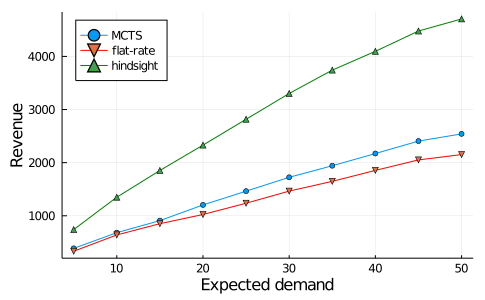

In [7]:
edf1 = mdf
sort!(edf1)
x_param = :demand

plot(edf1[!, x_param], edf1.r_mc,
    xlabel = label_demand,
    ylabel = "Revenue",
    label = "MCTS",
    m=(3, :circle), 
    size=plot_size,
    legend=:topleft
)
plot!(edf1[!, x_param], edf1.r_flat,  m=(3, :dtriangle), line=(:red), label="flat-rate")
plot!(edf1[!, x_param], edf1.r_hind,  m=(3, :utriangle), line=(:green), label="hindsight")

In [8]:
savefig(papersdir("paper_AAMAS2021_MCTS_pricing", "fig", "plt_big_d_r.pdf"))

# Varying demand - small - REV

In [54]:
df_s_r = collect_results( datadir("sims", "exp_small_r");
    subfolders=true)

┌ Info: Scanning folder C:\Users\Honza\scth\projects\julia\PricingMDP\data\sims\exp_small_r for result files.
└ @ DrWatson C:\Users\Honza\.julia\packages\DrWatson\YmBBf\src\result_collection.jl:88
┌ Info: Added 8 entries.
└ @ DrWatson C:\Users\Honza\.julia\packages\DrWatson\YmBBf\src\result_collection.jl:118


,flat,memallocs
,NamedTu…?,GC_Diff…?
1,"(r = 120.0, u = 6.0)","GC_Diff(44134742640, 5076, 79, 977875279, 43179, 0, 8643376692, 209, 7)"
2,"(r = 107.25, u = 5.55)","GC_Diff(38783008736, 4980, 39, 747666755, 44904, 0, 7553596396, 202, 8)"
3,"(r = 108.0, u = 5.4)","GC_Diff(40639221488, 5011, 55, 827879451, 43821, 0, 6956714299, 187, 5)"
4,"(r = 105.0, u = 5.25)","GC_Diff(40111703491, 5023, 55, 854455177, 42316, 0, 7486937711, 126, 4)"
5,"(r = 101.75, u = 5.3)","GC_Diff(32494352080, 4953, 28, 585736508, 40880, 0, 6288519984, 179, 6)"
6,"(r = 80.0, u = 4.25)","GC_Diff(32715026429, 5036, 27, 468450696, 43391, 0, 6712172311, 241, 5)"
7,"(r = 92.5, u = 4.95)","GC_Diff(33176640560, 4927, 27, 507898496, 41065, 0, 6216891797, 210, 5)"
8,"(r = 88.0, u = 4.65)","GC_Diff(35487723040, 4935, 26, 589668254, 43103, 0, 6537074510, 210, 5)"


In [55]:
df = df_s_r
r_flat =  get_result(df, :r, :flat)
r_mc=get_result(df, :r, :mc)
r_vi=get_result(df, :r, :vi)
r_hind =get_result(df, :r, :hind);

u_flat =  get_result(df, :u, :flat)
u_mc=get_result(df, :u, :mc)
u_vi=get_result(df, :u, :vi)
u_hind =get_result(df, :u, :hind);

n_runs = get_param(df, :exp, :n_runs)
n_iterations = get_param(df, :mcts, :n_iterations) 
demand = map(sum, get_param(df, :mdp, :demand))

mdf = DataFrame(@dict r_flat r_mc r_vi r_hind u_flat u_mc u_vi u_hind n_runs n_iterations demand )
sort!(mdf)

,demand,n_iterations,n_runs,r_flat,r_hind,r_mc,r_vi,u_flat,u_hind
,Float64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,9.0,5000,20,80.0,132.75,94.75,94.0,4.25,5.75
2,12.0,5000,20,92.5,135.75,96.25,101.75,4.95,5.85
3,15.0,5000,20,88.0,141.25,98.5,104.75,4.65,5.9
4,18.0,5000,20,101.75,146.75,114.0,121.25,5.3,5.95
5,21.0,5000,20,107.25,149.0,111.5,127.25,5.55,6.0
6,24.0,5000,20,108.0,152.25,120.0,130.25,5.4,6.0
7,27.0,5000,20,105.0,152.25,114.25,131.25,5.25,6.0
8,30.0,5000,20,120.0,153.0,127.25,128.75,6.0,6.0


In [57]:
mdf_old = CSV.read(datadir("exp_pro", "exp_small_d_r.csv"), DataFrame; delim=";")

,demand,n_iterations,n_runs,r_flat,r_hind,r_mc,r_vi,u_flat,u_hind
,Float64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.5,5000,100,23.1,46.35,27.4,27.35,1.73,2.53
2,3.0,5000,100,41.6,80.0,46.65,49.6,2.7,4.12
3,4.5,5000,100,54.0,98.6,61.4,64.6,3.19,4.8
4,6.0,5000,100,65.5,113.65,75.05,77.55,3.56,5.32
5,7.5,5000,100,72.9,123.25,82.75,84.65,4.35,5.49
6,9.0,5000,100,79.5,131.85,91.4,97.05,4.35,5.75
7,12.0,5000,20,92.5,135.75,96.25,101.75,4.95,5.85
8,15.0,5000,20,88.0,141.25,98.5,104.75,4.65,5.9
9,18.0,5000,20,101.75,146.75,114.0,121.25,5.3,5.95


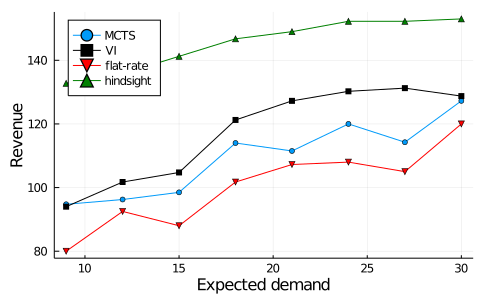

In [58]:
edf1 = mdf
sort!(edf1)
x_param = :demand


plot(edf1[!, x_param], edf1.r_mc,
    xlabel = label_demand,
    ylabel = "Revenue",
    label = "MCTS",
    m=(3, :circle), 
    size=plot_size,
    legend=:topleft
)
plot!(edf1[!, x_param], edf1.r_vi,  m=(3, :square, :black), line=(:black), label="VI")
plot!(edf1[!, x_param], edf1.r_flat,  m=(3, :dtriangle, :red), line=(:red), label="flat-rate")
plot!(edf1[!, x_param], edf1.r_hind,  m=(3, :utriangle, :green), line=(:green), label="hindsight")

# plot(edf1[!, x_param], edf1.u_mc,
#     label = "MCTS",
#     m=(3, :circle, :white), 
#     size=plot_size,
#     legend=:topleft, axis=:right
# )
# plot!(edf1[!, x_param], edf1.u_vi,  m=(3, :square, :white), line=(:black), label="VI")
# plot!(edf1[!, x_param], edf1.u_flat,  m=(3, :dtriangle, :white), line=(:red), label="flat-rate")
# plot!(edf1[!, x_param], edf1.u_hind,  m=(3, :utriangle, :white), line=(:green), label="hindsight")

In [204]:
savefig(papersdir("paper_AAMAS2021_MCTS_pricing", "fig", "plt_small_d_r.pdf"))

# Varying demand - small - UTIL

In [13]:
df_s_u = collect_results(
    datadir("sims", "exp_small_u"),
    subfolders=true
)

┌ Info: Scanning folder C:\Users\Honza\scth\projects\julia\PricingMDP\data\sims\exp_small_u for result files.
└ @ DrWatson C:\Users\Honza\.julia\packages\DrWatson\YmBBf\src\result_collection.jl:88
┌ Info: Added 6 entries.
└ @ DrWatson C:\Users\Honza\.julia\packages\DrWatson\YmBBf\src\result_collection.jl:118


,flat,memallocs
,NamedTu…?,GC_Diff…?
1,"(r = 4.91, u = 0.0)","GC_Diff(87265297248, 52, 3, 1087204946, 61208, 0, 14713965069, 404, 3)"
2,"(r = 4.56, u = 0.0)","GC_Diff(85748074512, 51, 3, 994377152, 50263, 0, 14246161695, 450, 5)"
3,"(r = 4.08, u = 0.0)","GC_Diff(73460917408, 49, 3, 795191078, 34656, 0, 11249435608, 201, 2)"
4,"(r = 5.11, u = 37.35)","GC_Diff(86014728368, 81, 3, 1235532105, 71397, 0, 14746390499, 255, 4)"
5,"(r = 5.08, u = 0.0)","GC_Diff(89182167968, 75, 3, 1195690932, 67808, 0, 15445312494, 388, 3)"
6,"(r = 2.59, u = 0.0)","GC_Diff(57733659204, 52, 3, 575542773, 14944, 0, 9134546097, 106, 0)"


## boxplot

In [10]:
df_s_r

rs_highest_demand = df_s_r.rs[5]
# order of values is mc, vi, hindsight
rs = DataFrame(transpose(hcat(rs_highest_demand...)), [:mc, :vi, :hind])

,mc,vi,hind
,Float64,Float64,Float64
1,35.0,90.0,110.0
2,0.0,0.0,20.0
3,100.0,70.0,135.0
4,20.0,20.0,20.0
5,90.0,95.0,145.0
6,40.0,45.0,115.0
7,80.0,75.0,110.0
8,70.0,70.0,95.0
9,35.0,35.0,70.0


In [27]:
df_s_r.flat

6-element Array{Union{Missing, NamedTuple{(:r, :u),Tuple{Float64,Float64}}},1}:
 (r = 54.0, u = 3.19)
 (r = 23.1, u = 1.73)
 (r = 72.9, u = 4.35)
 (r = 65.5, u = 3.56)
 (r = 41.6, u = 2.7)
 (r = 79.5, u = 4.35)

In [26]:
names(df_s_r)

12-element Array{String,1}:
 "flat"
 "memallocs"
 "params"
 "mdp_mc"
 "u"
 "r"
 "bytes"
 "mdp_vi"
 "rs"
 "us"
 "t"
 "path"

In [56]:
# revenues for highest demand
rs_highest_demand = df_s_u.rs[5]
# order of values is mc, vi, hindsight
rs = DataFrame(transpose(hcat(rs_highest_demand...)), [:mc, :vi, :hind])

,mc,vi,hind
,Float64,Float64,Float64
1,6.0,6.0,6.0
2,5.0,5.0,6.0
3,6.0,6.0,6.0
4,6.0,6.0,6.0
5,5.0,5.0,6.0
6,6.0,6.0,6.0
7,6.0,4.0,6.0
8,5.0,5.0,6.0
9,6.0,6.0,6.0


In [85]:
save(datadir("exp_pro", "small_us.csv"), rs)

In [12]:
using StatsPlots
#using CSVFiles

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1260


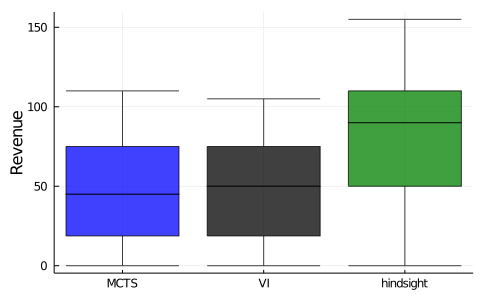

In [23]:
boxplot(ones(100), rs.mc; label="MCTS", color=:blue, alpha=0.75, 
    legend=false, 
    ylabel="Revenue", 
    xtick = ([1,2,3],["MCTS","VI","hindsight"]), 
    size=plot_size
)
boxplot!(2*ones(100), rs.vi, label="VI", color=:black, alpha=0.75)
boxplot!(3*ones(100), rs.hind, color=:green, alpha=0.75, label="hindsight")

In [24]:
savefig(papersdir("paper_AAMAS2021_MCTS_pricing", "fig", "plt_small_boxplot.pdf"))

## plot

In [44]:
r_flat =  get_result(df, :r, :flat)
r_mc=get_result(df, :r, :mc)
r_vi=get_result(df, :r, :vi)
r_hind =get_result(df, :r, :hind);

u_flat =  get_result(df, :u, :flat)
u_mc=get_result(df, :u, :mc)
u_vi=get_result(df, :u, :vi)
u_hind =get_result(df, :u, :hind);

n_runs = get_param(df, :exp, :n_runs)
n_iterations = get_param(df, :mcts, :n_iterations) 
demand = map(sum, get_param(df, :mdp, :demand))

mdf = DataFrame(@dict r_flat r_mc r_vi r_hind u_flat u_mc u_vi u_hind n_runs n_iterations demand )
sort!(mdf)

,demand,n_iterations,n_runs,r_flat,r_hind,r_mc,r_vi,u_flat,u_hind
,Float64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.5,5000,100,2.59,2.81,2.57,2.6,0.0,2.81
2,3.0,5000,100,4.08,4.49,4.09,4.07,0.0,4.49
3,4.5,5000,100,4.56,5.24,4.75,4.76,0.0,5.24
4,6.0,5000,100,4.91,5.72,5.2,5.21,0.0,5.72
5,7.5,5000,100,5.08,5.86,5.45,5.48,0.0,5.86
6,9.0,5000,100,5.11,5.95,5.66,5.72,37.35,5.95


In [9]:
mdf = CSV.read(datadir("exp_pro", "exp_small_d_u.csv"), DataFrame; delim=";")

,demand,n_iterations,n_runs,r_flat,r_hind,r_mc,r_vi,u_flat,u_hind
,Float64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.5,5000,100,2.59,2.81,2.57,2.6,0.0,2.81
2,3.0,5000,100,4.08,4.49,4.09,4.07,0.0,4.49
3,4.5,5000,100,4.56,5.24,4.75,4.76,0.0,5.24
4,6.0,5000,100,4.91,5.72,5.2,5.21,0.0,5.72
5,7.5,5000,100,5.08,5.86,5.45,5.48,0.0,5.86
6,9.0,5000,100,5.11,5.95,5.66,5.72,37.35,5.95


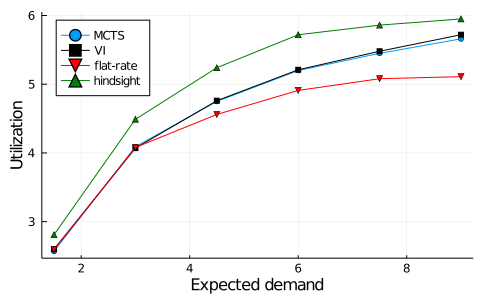

In [10]:
edf1 = mdf
sort!(edf1)
x_param = :demand


plot(edf1[!, x_param], edf1.r_mc,
    xlabel = label_demand,
    ylabel = "Utilization",
    label = "MCTS",
    m=(3, :circle), 
    size=plot_size,
    legend=:topleft
)
plot!(edf1[!, x_param], edf1.r_vi,  m=(3, :square, :black), line=(:black), label="VI")
plot!(edf1[!, x_param], edf1.r_flat,  m=(3, :dtriangle, :red), line=(:red), label="flat-rate")
plot!(edf1[!, x_param], edf1.r_hind,  m=(3, :utriangle, :green), line=(:green), label="hindsight")

# plot(edf1[!, x_param], edf1.u_mc,
#     label = "MCTS",
#     m=(3, :circle, :white), 
#     size=plot_size,
#     legend=:topleft, axis=:right
# )
# plot!(edf1[!, x_param], edf1.u_vi,  m=(3, :square, :white), line=(:black), label="VI")
# plot!(edf1[!, x_param], edf1.u_flat,  m=(3, :dtriangle, :white), line=(:red), label="flat-rate")
# plot!(edf1[!, x_param], edf1.u_hind,  m=(3, :utriangle, :white), line=(:green), label="hindsight")

In [11]:
savefig(papersdir("paper_AAMAS2021_MCTS_pricing", "fig", "plt_small_d_u.pdf"))

# Compare big and small rev

In [8]:
using CSV

In [48]:
c_0 = 10*30
mdf_big = CSV.read(datadir("exp_pro", "exp_big_d_r.csv"), DataFrame; delim=";")

mdf_big[!, "s/d"] = c_0 ./ mdf_big.demand ./10 .*(1+2+3+4+5+6+7+8+9+10)
mdf_big[!, "h/mc"] = mdf_big.r_hind ./ mdf_big.r_mc

10-element Array{Float64,1}:
 1.9134590545078791
 1.9781620987835264
 2.0376030786146235
 1.934833139631413
 1.9242434592526811
 1.9148356426459505
 1.926629595304294
 1.8858247778647392
 1.8609183461458552
 1.8510738730233658

In [49]:
mdf_big[!, ["demand", "s/d", "h/mc"]]

,demand,s/d,h/mc
,Float64,Float64,Float64
1,5.0,330.0,1.91346
2,10.0,165.0,1.97816
3,15.0,110.0,2.0376
4,20.0,82.5,1.93483
5,25.0,66.0,1.92424
6,30.0,55.0,1.91484
7,35.0,47.1429,1.92663
8,40.0,41.25,1.88582
9,45.0,36.6667,1.86092


In [50]:
c_0 = 3*2
mdf_small = CSV.read(datadir("exp_pro", "exp_small_d_r.csv"), DataFrame; delim=";")
mdf_small[!, "s/d"] = c_0 ./ mdf_small.demand ./3 .* (1+2+3)
mdf_small[!, "h/mc"] = mdf_small.r_hind ./ mdf_small.r_mc
mdf_small[!, ["demand", "s/d", "h/mc"]]

,demand,s/d,h/mc
,Float64,Float64,Float64
1,1.5,8.0,1.69161
2,3.0,4.0,1.7149
3,4.5,2.66667,1.60586
4,6.0,2.0,1.51432
5,7.5,1.6,1.48943
6,9.0,1.33333,1.44256
